# Lets talk Restricted Boltzmann Machines (RBM)!!

### Structure
An RBM is formulated as a bipartite graph of random variables (RV).  
One half of the graph are visible RV's,  
the other half "hidden" RV's.  
It models a joint probability distribution over all the RV's

![](http://deeplearning.net/tutorial/_images/rbm.png)

### Intuition
One intuition for the RBM is that the visible RV's are not independent and are in fact a result of some underlying process you are not privy to (the hidden RV's)
Each edge of the graph carries a weight defining the coupling between the RV's at its ends.

### Objective Function
An RBM has an additional property in its formulation, an Energy.  
$$ E(v,h) = -hWv $$
The energy is a measure of how well tightly coupled RV's agree when sampled.  
*Note that better agreement leads to lower energy.  
This objective is inspired by the concept of energy in physical systems involving Electromagnetic effects of interacting particles.  
With this energy we can define the probability of a visible vector of RV's as:  
$$ p(v) = \sum_h {\frac{e^{-E(v,h)}}{Z}} $$  
Where Z is the sum of $e^{-E(v,h)}$ over every combination of v & h

### Training  
Maximizing $p(v)$ cannot be done in closed form and involves some sort of search. In addition, the stochastic, unsupervised nature of an RBM makes this search hard.  
As an example, to maximize $p(v)$ using gradient descent involves finding the derivative of $p(v)$ yielding $$\sum_{\hat{v},\hat{h}} p(\hat{v},\hat{h}) \frac{d\ E(\hat{v},\hat{h})}{ d\ W}$$  
Finding the sum of these terms over every possible combination of $\hat{v}, \hat{h}$ is intractable.  
Just like the physical systems RBM's are inspired by, the RBM will naturally minimize its energy state when sampled.  Therefore when training we want to minimize the energy state of the RBM under the conditions of the known visible RV's.  
An RBM is generally trained using an unsupervised learning algorithm called Constrastive Divergence shown below.

## Let's prep for a dead simple example

In [435]:
%matplotlib inline

In [436]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
import sys
import matplotlib.pyplot as plt

In [437]:
def show_distribution(d):
    fig, ax = plt.subplots(figsize=(20,10))
    w = 1.0
    d = (d * np.asarray([4,2,1])).sum(axis=1)
    d_hist,edges = np.histogram(d,bins=8,range=(0,7))
    print(edges)
    ax.bar(np.arange(8),d_hist,w )
    ax.set_xticks(np.arange(8) + w/2)
    ax.set_xticklabels(('Nothing','E','D','D,E','B', 'B,E','B,D', 'Everything'), fontsize=24)
    plt.show()
    
def drawRBM( v, h, v_hat, h_hat):
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(121, xlim=(-1.5,1.5),ylim=(-0.5,1.5))
    ax_hat = fig.add_subplot(122, xlim=(-1.5,1.5),ylim=(-0.5,1.5))
    for axes, visible, hidden in [(ax,v,h), (ax_hat, v_hat, h_hat)]:
        c = 'k'
        for x,v in enumerate(visible):
            if v:
                c = 'r'
            else:
                c = 'k'
            x_t = x-(len(visible)-1)/2.0
            axes.plot((0,x_t),(1,0),'k')
            axes.add_patch(plt.Circle((x_t,0), radius = 0.2, fc=c))
        for x,h in enumerate(hidden):
            if h:
                c = 'r'
            else:
                c = 'k'
            axes.add_patch(plt.Circle((x,1), radius = 0.2, fc=c))

def showRBMParams(rbm):
    fig, ax = plt.subplots(figsize=(20,6))
    w = 1.0
    dat = reduce(np.append,[rbm.components_.flatten() , rbm.intercept_visible_ , rbm.intercept_hidden_])
    ax.bar(np.arange(len(dat)),dat,w, color=['g','g','g','b','b','b','r'] )
    ax.set_xticks(np.arange(len(dat)) + w/2)
    ax.set_xticklabels(('h->Beer', 'h->Diapers', 'h->Energy Drink','Beer', 'Diapers', 'Energy Drink','h'),fontsize=20)
    plt.show()
#     fig, ax = plt.subplots()
#     w = 1.0
#     ax.bar(np.arange(len(rbm.intercept_visible_)),rbm.intercept_visible_,w )
#     ax.set_xticks(np.arange(len(rbm.intercept_visible_)) + w/2)
#     ax.set_xticklabels(('Beer', 'Diapers', 'Energy Drinks'))
#     plt.show()
#     fig, ax = plt.subplots()
#     w = 1.0
#     ax.bar(np.arange(3),[0,rbm.intercept_hidden_,0],w )
#     ax.set_xticks(np.arange(3) + w/2)
#     ax.set_xticklabels(('','????',''))
#     plt.show()

## The Training Data.

We all remember the frequently purchased items.  
We will work with just 3 for simplicity
### (Beer, Diapers, Energy Drink)  
Let's encode these as a binary vector. i.e. 
$$ \{ Beer, Diapers \} \rightarrow (1,1,0) $$  
Let's assume the following ideal distribution:  
0.3 (Beer, Diapers)  
0.3 (Beer, Energy Drink)  
0.1 (Beer)  
0.2 (Diapers)  
0.1 (Energy Drink)  

In [438]:
n_training_samples = 10000

In [439]:
lower_cutoffs = {0.0:(0,0,1),
                 0.1:(0,1,0),
                 0.3:(1,0,0),
                 0.4:(1,0,1),
                 0.7:(1,1,0)}
data = np.zeros((n_training_samples,3), dtype=np.bool_)
counts = np.zeros(len(lower_cutoffs))
draws = np.random.rand(n_training_samples)
upperbound = 1.0
cuts = sorted(lower_cutoffs.keys())
cuts.reverse()
for c,k in enumerate(cuts):
        i = np.logical_and(draws<upperbound,draws>=k)
        pattern = lower_cutoffs[k]
        counts[c] = np.sum(i)
        data[i,:] = pattern
        upperbound = k



[ 0.     0.875  1.75   2.625  3.5    4.375  5.25   6.125  7.   ]


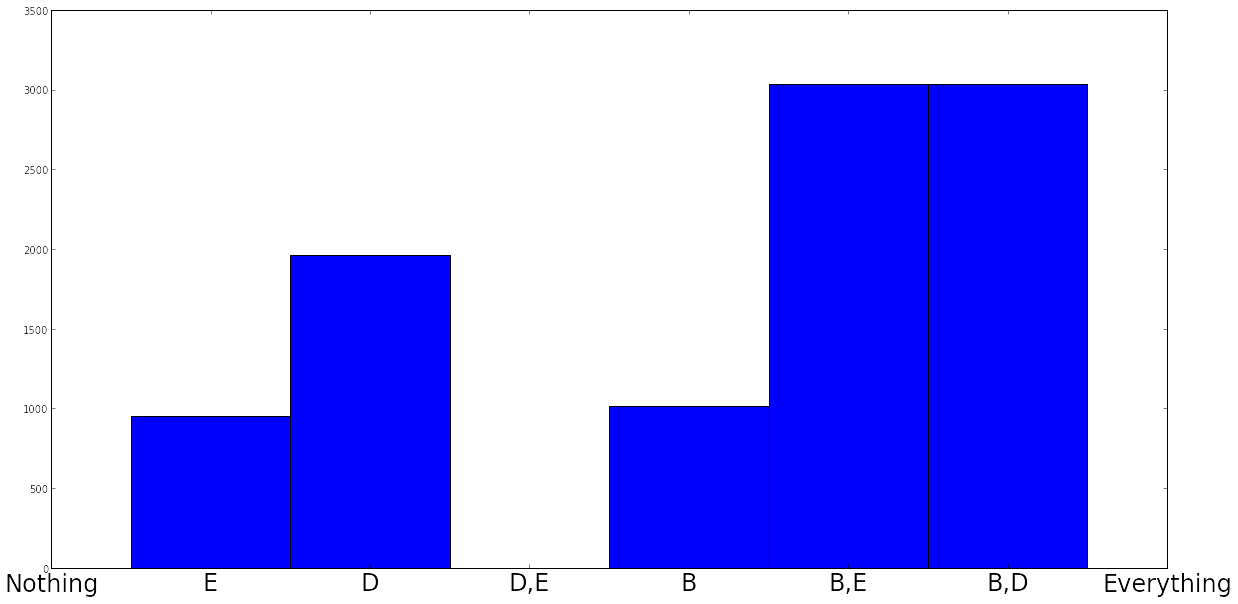

In [440]:
show_distribution(data)

## So far so good!

Let's formulate our RBM
We will need 3 visible RV's for the different items.  
Let's go simple and include only 1 hidden RV.

![](./3_1.png)

In [441]:
rbm = BernoulliRBM(n_components=1, learning_rate=0.09,batch_size=32,n_iter=20)
rbm.partial_fit(np.zeros((1,3)))
rbm.intercept_hidden_  = np.zeros(rbm.intercept_hidden_.shape)
rbm.intercept_visible_ = np.zeros(rbm.intercept_visible_.shape)
rbm.components_ = np.zeros(rbm.components_.shape)
print("Weights: {}".format(rbm.components_))
print("Visible Bias: {}".format(rbm.intercept_visible_))
print("Hidden Bias: {}".format(rbm.intercept_hidden_))

Weights: [[ 0.  0.  0.]]
Visible Bias: [ 0.  0.  0.]
Hidden Bias: [ 0.]


### Training Time (baby steps)  

Let's do a couple training steps in slo-mo so we can get a feel for how this goes.

In [442]:
train_index = 0

#### First we need to take some samples  $h, \hat{v}, \hat{h}$

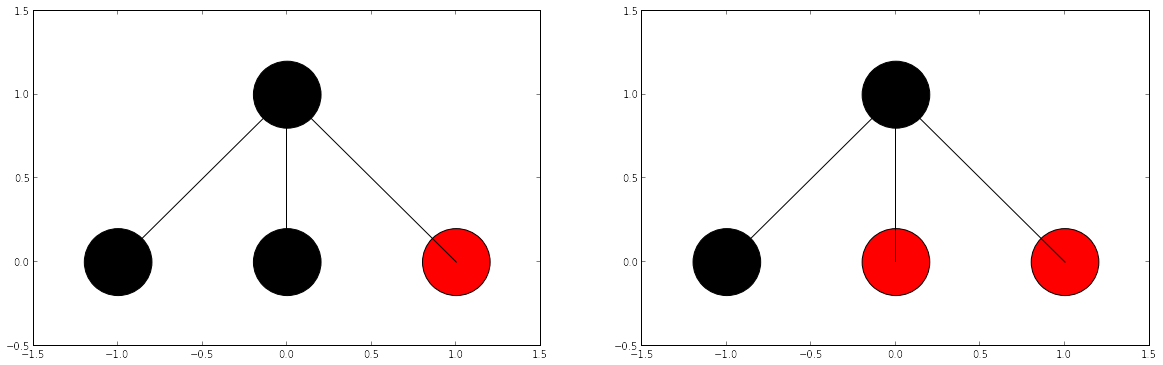

In [445]:
v = data[train_index,:]
h = rbm._sample_hiddens(v, rbm.random_state_)
v_hat = rbm._sample_visibles(h,rbm.random_state_)
h_hat = rbm._sample_hiddens(v_hat, rbm.random_state_)
drawRBM(v,h, v_hat, h_hat)
train_index +=1

Now we can promote the positive particle $\{v,h\}$  
and demote the negative particle $\{\hat{v}, \hat{h}\}$

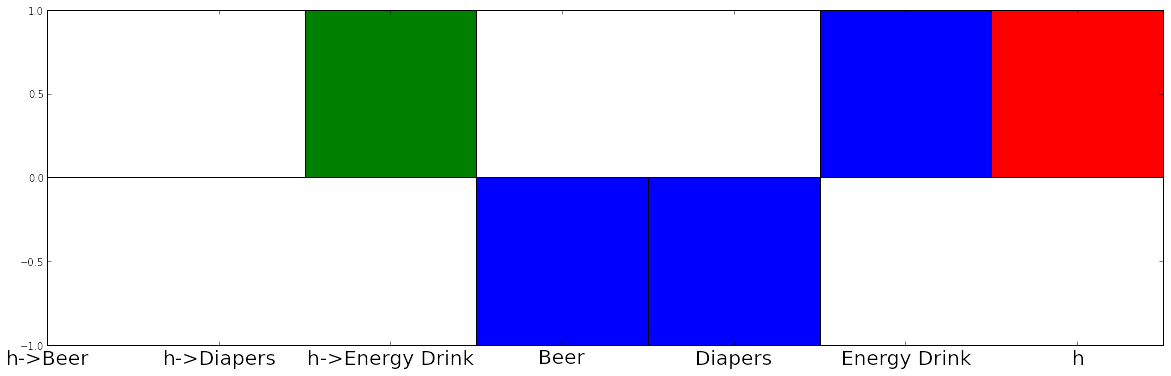

In [446]:
def f(x):
    return x.astype(np.float)

rbm.intercept_hidden_ += f(h) - f(h_hat)
rbm.intercept_visible_ += f(v) - f(v_hat)
#rbm.components_ += np.dot(h.transpose(),v) - np.dot(h_hat.transpose(),v_hat)
rbm.components_ += f(h)*f(v) - f(h_hat)*f(v_hat)
showRBMParams(rbm)

In [448]:
rbm.fit(data)


BernoulliRBM(batch_size=32, learning_rate=0.09, n_components=1, n_iter=20,
       random_state=None, verbose=0)

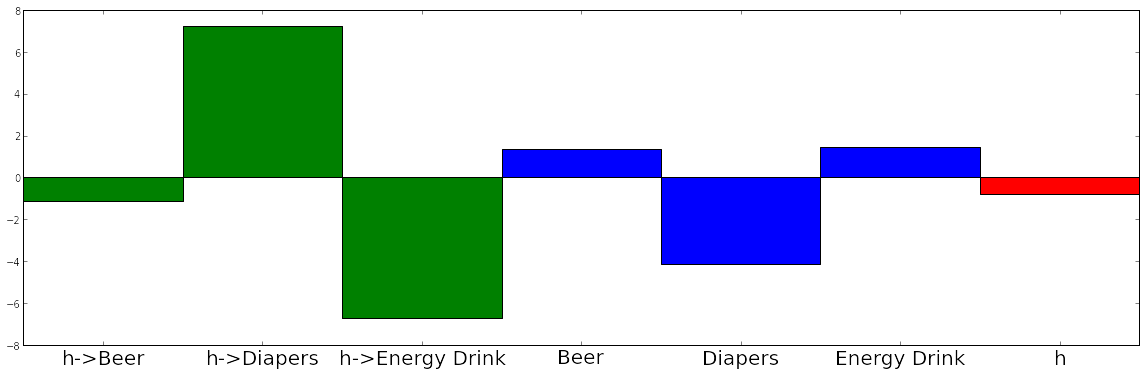

In [449]:
showRBMParams(rbm)

In [450]:
i = 0
N = 10000
generated_samples = np.zeros([N,3])

In [451]:
while i < N:
    v = np.random.randint(0,2,size=3)
    for j in range(20):
        v = rbm.gibbs(v)
    generated_samples[i,:] = v
    i +=1

[ 0.     0.875  1.75   2.625  3.5    4.375  5.25   6.125  7.   ]


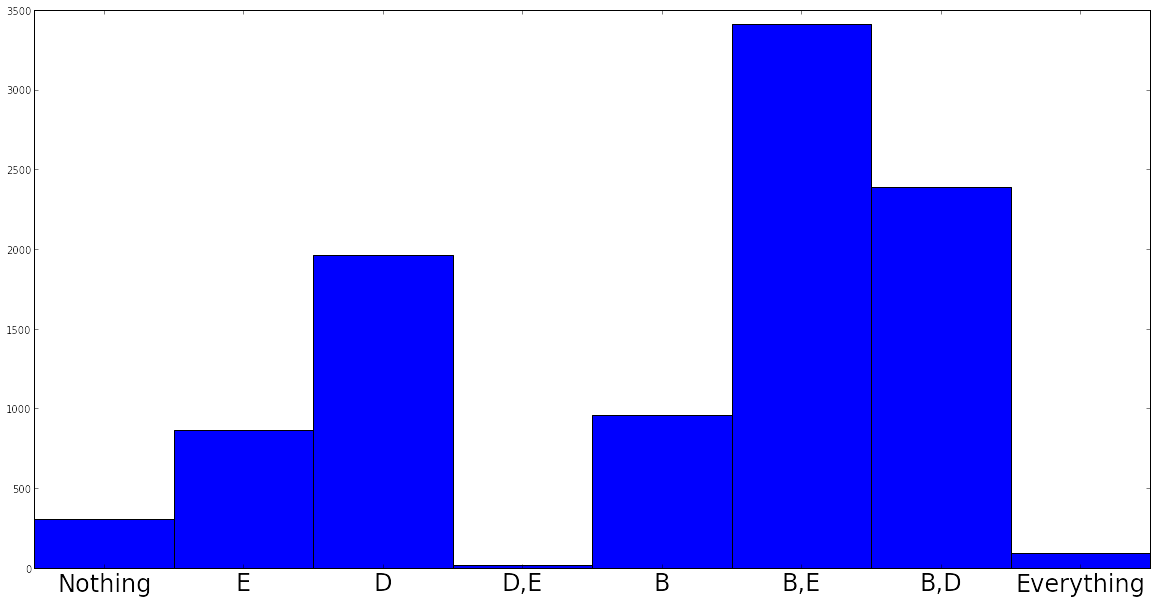

In [452]:
show_distribution(generated_samples)